# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.
- Do not modify the random seed, as they are needed for reproducibility purpose.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

## Example

### Loading packages and libraries

In [28]:
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F


# Fix all random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

Using device: cuda


In [29]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

def evaluate(model):
    params_count = sum(p.numel() for p in model.parameters())
    print('The model has {} parameters'.format(params_count))

    if params_count > int(1e6):
        print('The model has too many parameters! Not allowed to evaluate.')
        return

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # print in bold red in a notebook
    print('\033[1m\033[91mAccuracy on the test set: {}%\033[0m'.format(100 * correct / total))


Since we are not allowed to use the testset which is normal , we then define a training and validation set so we can evaluate properly the training set with the validation set.

In [30]:
# load the train dataset
train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

# Split the dataset into 40k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)


In [31]:
from typing import Optional, Tuple, List
import torch
from torch import nn
from torch.utils.data import DataLoader


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader] = None,
    criterion: Optional[nn.Module] = None,
) -> Tuple[List[float], List[float], List[float]]:
    """
    Calls train_epoch() for a specified number of epochs, and (optionally) evaluates on valid_dataloader.

    Modified so it also does the classic training-loop steps:
    - moves inputs/targets to device
    - forward pass
    - compute loss
    - backward
    - optimizer step

    If your existing train_epoch already does this, you can keep using it by passing
    a train_epoch that accepts `criterion`, or remove the inlined loop below.
    """

    if criterion is None:
        # default for classification; change if your task is different
        criterion = nn.CrossEntropyLoss()

    model.to(device)

    train_losses: List[float] = []
    valid_losses: List[float] = []
    valid_accs: List[float] = []

    for epoch in range(epochs):
        # ---- TRAIN (inlined training loop like your screenshot) ----
        model.train()
        running_loss = 0.0
        num_samples = 0

        for images, labels in train_dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            bs = images.size(0)
            running_loss += loss.item() * bs
            num_samples += bs

        train_loss = running_loss / max(1, num_samples)
        train_losses.append(train_loss)

        # ---- VALIDATION  ----
        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            print(
                f"Epoch {epoch}: Train Loss={train_loss:.4f}, "
                f"Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}"
            )
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")

    return train_losses, valid_losses, valid_accs

In [32]:
from typing import List, Optional


def plot_losses(
    train_losses: List[float],
    valid_losses: Optional[List[float]] = None,
    title: str = "Loss per epoch",
) -> None:
    """
    Plots training loss (and optional validation loss) vs epoch.

    Usage:
        train_losses, valid_losses, valid_accs = fit(...)
        plot_losses(train_losses, valid_losses)
    """
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure()
    plt.plot(epochs, train_losses, label="train loss")

    if valid_losses is not None and len(valid_losses) > 0:
        # If valid_losses length differs (shouldn't, but safe), align to its length
        v_epochs = list(range(1, len(valid_losses) + 1))
        plt.plot(v_epochs, valid_losses, label="valid loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [36]:
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader


@torch.no_grad()
def predict(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    verbose: bool = True,
) -> Tuple[float, float]:
    """
    Evaluates a classification model and returns:
      - average loss over all samples
      - accuracy over all samples

    Assumes dataloader yields (inputs, labels) and model outputs logits of shape (B, num_classes).
    Uses CrossEntropyLoss by default (standard for CIFAR-100 classification).
    """
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(reduction="sum")  # sum to average properly over samples

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in dataloader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)  # logits
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / max(1, total_samples)
    acc = total_correct / max(1, total_samples)

    if verbose:
        print(f"Loss={avg_loss:.4f}, Accuracy={acc:.4f}")

    return avg_loss, acc

## Model Architecture Used  : ResNet

In the lab, we used a ResNet as the final model for CIFAR-10, so we will start from the same baseline here. However, the ResNet used for CIFAR-10 has over 1 million parameters, so we decided to change a bit the architecture first . In fact , the model begins with 64 channels and then increases the width at each stage to 128, 256, and 512 channels. With two 3×3 convolutions per block, most of the parameters come from convolution layers, and the number of convolution parameters scales as $3\cdot 3\cdot C_{in}\cdot C_{out}$. As a result, doubling the number of channels roughly multiplies the parameter count by about four, meaning the later stages (especially the 256→512 part) dominate the total number of parameters.

Since our goal is to train on CIFAR-100 while keeping the model efficient, we decided to reduce the parameter count rather than increasing model capacity further. CIFAR-100 images are only 32×32, and after several downsampling steps the spatial resolution becomes very small (e.g., 8×8 then 4×4). At that point, having 512 channels can be unnecessarily expensive: it increases computation and memory usage and can also increase the risk of overfitting without guaranteeing better generalization.

Therefore, we redesigned the network by reducing the width (for example starting at 32 instead of 64) and/or capping the maximum number of channels (for example 256 instead of 512). This directly reduces parameters because it lowers $C_{in}$ and $C_{out}$ in every convolution, giving a large reduction with a minimal change to the overall architecture. Importantly, we keep the same global structure (stacked convolutional blocks with occasional downsampling and global average pooling) so that the model preserves the same inductive bias that works well on CIFAR-style datasets, while being more efficient and better matched to the dataset and compute constraints.


## Hyperparameters : Batch Size , Learning Rate and Momemtum

We will focus now  on improving performance by tuning the training setup: the optimizer, the learning rate (and its schedule), the batch size, and related hyperparameters.

The choice of optimizer and its hyperparameters plays a crucial role in final accuracy and training stability. Therefore, we will run cross-validation directly on the ResNet to select these settings properly. The motivation is that we want training to progress quickly while still converging to a good solution. With a learning rate that is too small, ResNet training is usually stable but slow; with a learning rate that is too large, updates can become unstable, the loss can oscillate, parameters may overshoot good regions, and convergence can fail. Large updates can also amplify exploding or vanishing gradient effects through the repeated gradient multiplications of backpropagation, which can prevent early layers from learning effectively.

The goal is to achieve the best trade-off: fast learning without sacrificing stability, and this is exactly what careful hyperparameter selection (optimizer, learning rate, batch size, and scheduling) is meant to provide.


In [47]:
class NonResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, base=32, max_planes=128):
        super().__init__()
        self.in_planes = base

        self.conv1 = nn.Conv2d(3, base, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(base)

        # widths: base, 2*base, 4*base, 8*base but capped
        widths = [base, min(2*base, max_planes), min(4*base, max_planes), min(8*base, max_planes)]

        self.layer1 = self._make_layer(block, widths[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, widths[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, widths[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, widths[3], num_blocks[3], stride=2)

        self.fc = nn.Linear(widths[3], num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.adaptive_avg_pool2d(out, 1)   # (B, C, 1, 1)
        out = torch.flatten(out, 1)           # (B, C)
        out = self.fc(out)
        return out

print("Model parameters: ", sum(p.numel() for p in ResNet(block=NonResidualBlock, num_blocks=[1,1,1,1]).parameters()))


Model parameters:  605060


In [49]:
# Grid of Hyperparameters

learning_rates = [0.3,0.2,0.1]
batch_sizes =  [128, 256,]
momentums = [0.7,0.9]

In [51]:
# Let's run cross validation on the three components :
for l_r in learning_rates:
    for b_s in batch_sizes:
      for mt in momentums:

        # define the hyperparameters
        BATCH_SIZE = b_s
        TEST_BATCH_SIZE = 1024
        LEARNING_RATE = l_r


        train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2)

        valid_dataloader = DataLoader(
            dataset=valid_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)


        print(f"Training with lr={l_r}, batch_size={b_s} and , momentum = {mt} : ")

        # initialize model
        resnet = ResNet(block=NonResidualBlock, num_blocks=[1,1,1,1]).to(device)
        # define the optimizer
        optimizer = torch.optim.SGD(resnet.parameters(), lr=l_r, momentum=mt)

        # train the CNN
        losses = fit(
             model=resnet,
             train_dataloader=train_dataloader,
             valid_dataloader=valid_dataloader,
             optimizer=optimizer,
             epochs=10,
             device=device
             )


        print("***********************************************************")
        print("***********************************************************")
        print("***********************************************************")


Training with lr=0.3, batch_size=128 and , momentum = 0.5 : 
Epoch 0: Train Loss=3.8815, Validation Loss=4.2020, Validation acc=0.0729
Epoch 1: Train Loss=3.2550, Validation Loss=3.2549, Validation acc=0.2158
Epoch 2: Train Loss=2.7763, Validation Loss=2.9361, Validation acc=0.2585
Epoch 3: Train Loss=2.3864, Validation Loss=2.6447, Validation acc=0.3115
Epoch 4: Train Loss=2.0695, Validation Loss=2.5380, Validation acc=0.3546
Epoch 5: Train Loss=1.8101, Validation Loss=2.4284, Validation acc=0.3820
Epoch 6: Train Loss=1.5816, Validation Loss=2.2264, Validation acc=0.4270
Epoch 7: Train Loss=1.3752, Validation Loss=2.3797, Validation acc=0.4004
Epoch 8: Train Loss=1.2032, Validation Loss=2.3500, Validation acc=0.4397
Epoch 9: Train Loss=1.0215, Validation Loss=2.4917, Validation acc=0.4173
***********************************************************
***********************************************************
***********************************************************
Training with lr=0.

In [15]:
# Let's define for now a batchsize and learning rate to test

BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
learning_rate = 0.1

In [16]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

### Example of a simple CNN model

In [12]:
class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8*8*64, 128)
        self.fc2 = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model parameters: ", sum(p.numel() for p in TinyNet().parameters()))

Model parameters:  556708


**Actual CNN Model**

In [19]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):

        identity = x                         # save original input

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(identity)   # apply shortcut to original x
        out = out + shortcut                 # residual addition
        out = F.relu(out)


        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Epoch 0: Train Loss=4.6444
Epoch 1: Train Loss=4.1242
Epoch 2: Train Loss=3.8589
Epoch 3: Train Loss=3.6668
Epoch 4: Train Loss=3.4654
Epoch 5: Train Loss=3.2413
Epoch 6: Train Loss=3.0996
Epoch 7: Train Loss=2.8849
Epoch 8: Train Loss=2.6955
Epoch 9: Train Loss=2.4982
Epoch 10: Train Loss=2.2634
Epoch 11: Train Loss=2.0514
Epoch 12: Train Loss=1.8115
Epoch 13: Train Loss=1.6342
Epoch 14: Train Loss=1.3370
Epoch 15: Train Loss=1.1202
Epoch 16: Train Loss=0.7756
Epoch 17: Train Loss=0.4943
Epoch 18: Train Loss=0.3247
Epoch 19: Train Loss=0.2017
Epoch 20: Train Loss=0.1437
Epoch 21: Train Loss=0.1129
Epoch 22: Train Loss=0.1041
Epoch 23: Train Loss=0.0816
Epoch 24: Train Loss=0.0394
Epoch 25: Train Loss=0.0448
Epoch 26: Train Loss=0.0630
Epoch 27: Train Loss=0.0866
Epoch 28: Train Loss=0.0632
Epoch 29: Train Loss=0.0942
Epoch 30: Train Loss=0.0925
Epoch 31: Train Loss=0.1078
Epoch 32: Train Loss=0.1014
Epoch 33: Train Loss=0.0569
Epoch 34: Train Loss=0.0753


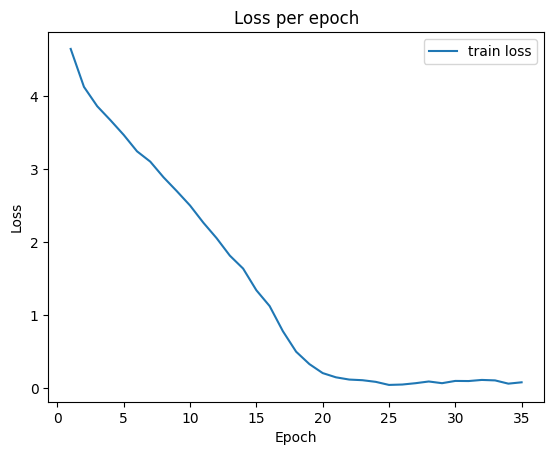

In [25]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(device)

criterion = torch.nn.CrossEntropyLoss()


# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = device
    )

plot_losses(train_losses)




### Example of basic training

In [13]:

model = TinyNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))


Epoch [1/10], Loss: 4.6038
Epoch [2/10], Loss: 4.5989
Epoch [3/10], Loss: 4.5938
Epoch [4/10], Loss: 4.5835
Epoch [5/10], Loss: 4.6095
Epoch [6/10], Loss: 4.5991
Epoch [7/10], Loss: 4.5833
Epoch [8/10], Loss: 4.5818
Epoch [9/10], Loss: 4.5808
Epoch [10/10], Loss: 4.5845


In [14]:
# save the model on a file
torch.save(model.state_dict(), 'tiny_net.pt')

loaded_model = TinyNet()
loaded_model.load_state_dict(torch.load('tiny_net.pt', weights_only=True))
evaluate(loaded_model)

The model has 556708 parameters
Accuracy on the test set: 2.6%


In [27]:
# save the model on a file
torch.save(model.state_dict(), 'res_net.pt')

loaded_model_1 = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2])
loaded_model_1.load_state_dict(torch.load('res_net.pt', weights_only=True))
evaluate(loaded_model_1)

The model has 11220132 parameters
The model has too many parameters! Not allowed to evaluate.
